# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [1]:
import json
import pandas as pd
from decimal import Decimal

# Utils
import src.utils.visualization.gantt_diagram as gantt

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.CP_Solver import Solver

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Database and Collections
from src.domain.Query import JobQuery
from src.domain.Collection import LiveJobCollection

In [3]:
# Hard termination condition for schedulers
max_time = 60*10     # 10 min

# File paths
examples_data_path = get_path("data", "examples")
logs_path = get_path("data", "logs")

# Simulation
simulation = ProductionSimulation(shift_length= 1440, sigma = 0.2)

In [4]:
jobs = JobQuery.get_by_max_bottleneck_utilization(Decimal("0.85"))
jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,1440,3296
1,01-08500-0016,01-07,1504,2880,5716
2,01-08500-0029,01-07,2352,2880,4598
3,01-08500-0034,01-07,2791,2880,4868
4,01-08500-0047,01-07,3513,4320,5939
5,01-08500-0053,01-07,3949,4320,7604
...,...,...,...,...,...
9598,01-08500-9541,01-08,715701,717120,719546
9599,01-08500-9557,01-08,717245,718560,720391
9600,01-08500-9566,01-08,718254,718560,721760


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)


In [7]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,M01-02,None,31,None,0,1440,3296
1,01-08500-0000,01-07,1,M01-00,None,86,None,0,1440,3296
2,01-08500-0000,01-07,2,M01-01,None,46,None,0,1440,3296
3,01-08500-0000,01-07,3,M01-05,None,74,None,0,1440,3296
4,01-08500-0000,01-07,4,M01-04,None,32,None,0,1440,3296
5,01-08500-0000,01-07,5,M01-06,None,88,None,0,1440,3296
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0012,01-08,4,M01-02,None,85,None,1084,1440,4116
155,01-08500-0012,01-08,5,M01-09,None,11,None,1084,1440,4116
156,01-08500-0012,01-08,6,M01-06,None,40,None,1084,1440,4116


In [8]:
df_jobs_times_current = current_jobs_collection.to_jobs_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,1440,3296
1,01-08500-0001,01-06,53,1440,2330
2,01-08500-0010,01-06,1002,1440,2738
3,01-08500-0002,01-01,125,1440,3773
4,01-08500-0015,01-01,1437,1440,3198
5,01-08500-0003,01-05,174,1440,3091
6,01-08500-0004,01-04,219,1440,4098
7,01-08500-0013,01-04,1178,1440,2917
8,01-08500-0005,01-02,443,1440,3578
9,01-08500-0011,01-02,1007,1440,2796


### Scheduling

In [9]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=None,
    active_jobs_collection=None,
    w_t = 5, w_e = 1, w_first = 1,
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

w_t=5, w_e=1, w_first=1 main_pct=1.0
{
  "number_of_operations_to_schedule": 160,
  "number_of_operations_with_previous_schedule": 0,
  "number_of_active_operation_to_consider": 0,
  "number_of_variables": 421,
  "number_of_constraints": 431
}


In [10]:
log_file_path = logs_path / "cp_lateness_with_w_first_init.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

{
  "status": "OPTIMAL",
  "objective_value": 11.0,
  "best_objective_bound": 11.0,
  "number_of_branches": 0,
  "wall_time": 0.06
}


In [11]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Deadline
0,01-08500-0000,01-07,0,M01-02,2113,31,2144,0,1440,3296
1,01-08500-0000,01-07,1,M01-00,2144,86,2230,0,1440,3296
2,01-08500-0000,01-07,2,M01-01,2249,46,2295,0,1440,3296
3,01-08500-0000,01-07,3,M01-05,2295,74,2369,0,1440,3296
4,01-08500-0000,01-07,4,M01-04,2369,32,2401,0,1440,3296
5,01-08500-0000,01-07,5,M01-06,2446,88,2534,0,1440,3296
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M01-03,2199,69,2268,1437,1440,3198
155,01-08500-0015,01-01,5,M01-01,2295,28,2323,1437,1440,3198
156,01-08500-0015,01-01,6,M01-06,2323,46,2369,1437,1440,3198


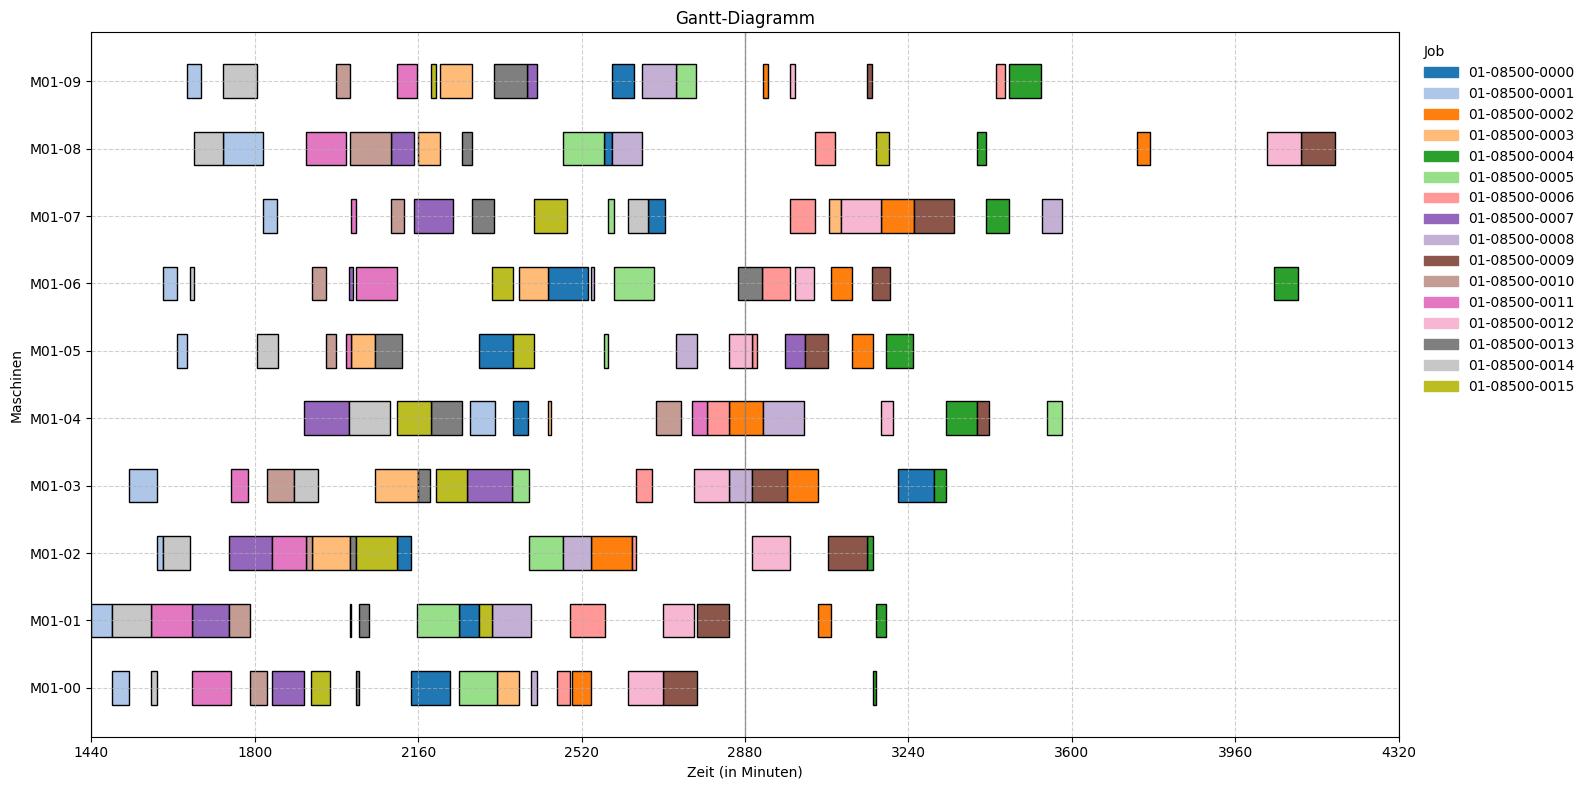

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [12]:
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


In [24]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
df_jobs_metrics

,Job,Routing_ID,Last Operation,End,Arrival,Ready Time,Deadline,Total Processing Time,Flowtime,Lateness,Tardiness,Earliness
0,01-08500-0000,01-07,9,3296,0,1440,3296,539,1856,0,0,0
1,01-08500-0001,01-06,9,2330,53,1440,2330,416,890,0,0,0
2,01-08500-0002,01-01,9,3773,125,1440,3773,510,2333,0,0,0
3,01-08500-0003,01-05,9,3091,174,1440,3091,496,1651,0,0,0
4,01-08500-0004,01-04,9,4098,219,1440,4098,393,2658,0,0,0
5,01-08500-0005,01-02,9,3578,443,1440,3578,568,2138,0,0,0
6,01-08500-0006,01-00,9,3453,753,1440,3453,395,2013,0,0,0
7,01-08500-0007,01-03,9,3012,896,1440,3012,655,1572,0,0,0
8,01-08500-0008,01-09,9,3579,962,1440,3579,540,2139,0,0,0
9,01-08500-0009,01-08,9,4179,979,1440,4179,597,2739,0,0,0


In [16]:
get_jobs_aggregated(df_jobs_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,16,0,0,0


In [21]:
get_jobs_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,15,0,0,0


### Simulation

In [ ]:
# simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)
simulation.initialize_run(schedule_collection = schedule_jobs_collection, start_time=day_start)

In [ ]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_operations_dataframe()
df_execution

In [ ]:
gantt.get_plot(df_execution, perspective="Machine")

In [ ]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_operations_dataframe()
df_active

In [ ]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_operations_dataframe()

## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [ ]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

In [ ]:
# New and previous jobs that must be scheduled
current_jobs_collection_temp = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_jobs_collection = current_jobs_collection_temp + waiting_job_ops_collection

In [ ]:
# Test
current_jobs_collection_temp.to_operations_dataframe()

In [ ]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

### Scheduling (Rescheduling)

In [ ]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_operations_dataframe()

#### a) Simple Scheduling

In [ ]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=None,         # simple scheduling
    active_jobs_collection=active_job_ops_collection,
    w_t = 5, w_e = 1, w_first = 1,
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_w_first_2_simple.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))


In [ ]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_simple.csv", index=False)
df_schedule

In [ ]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
get_jobs_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

### b) with 'start' deviation penalty

In [ ]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization(
    previous_schedule_jobs_collection=previous_schedule_jobs_collection,
    active_jobs_collection=active_job_ops_collection,
    w_t = 5, w_e = 1, w_first = 1,
    main_pct= (1/3),
    duration_buffer_factor= 2.5
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_w_first_2_dev.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

In [ ]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_dev.csv", index=False)
df_schedule

In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
get_jobs_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

#### Check the conditions of the combined data set from the simulation data with the new schedule

In [ ]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

In [ ]:
-

### Simulation

In [ ]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

In [ ]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

In [ ]:
gantt.get_plot(df_execution2, perspective="Machine")

In [ ]:
df_active2 = simulation.get_active_operations_df()
df_active2

#### Check the conditions of the combined data set from the two simulation data sets

In [ ]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)